In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

Here are all the necessary libraries

In [3]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [5]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


PyCOCOTools provides many utilities for dealing with datasets in the COCO format, and if you wanted, you could evaluate the model's performance on the dataset with some of the utilities provided with this library.

That is out of scope for this notebook, however.

In [6]:
# our dataset is in cocoformat, we will need pypcoco tools
from pycocotools.coco import COCO

In [7]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [8]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

### Dataset
This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [9]:
class HelmetDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [11]:
import zipfile

with zipfile.ZipFile('drive/MyDrive/data.zip', 'r') as zip_ref:
  zip_ref.extractall("drive/MyDrive/")

In [14]:
dataset_path = r"drive/MyDrive"

In [15]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


{0: {'id': 0, 'name': 'rider-helmet-bike', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'With Helmet', 'supercategory': 'rider-helmet-bike'},
 2: {'id': 2, 'name': 'Without Helmet', 'supercategory': 'rider-helmet-bike'}}

This code just gets a list of classes

In [16]:
classes = [i[1]['name'] for i in categories.items()]
classes

['rider-helmet-bike', 'With Helmet', 'Without Helmet']

In [17]:
len(classes)

3

In [18]:
train_dataset = HelmetDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

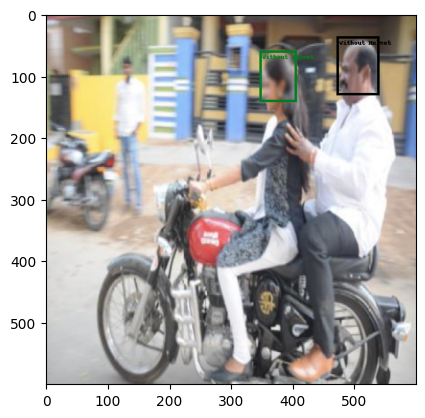

In [19]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [20]:
len(train_dataset)

1182

### Model
Our model is FasterRCNN with a backbone of MobileNetV3-Large. We need to change the output layers because we have just 6 classes but this model was trained on 90 classes.

In [21]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 143MB/s]


This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [24]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [27]:
import os
import sys
import dill

def save_object(file_path: str, obj: object) -> None:
    logging.info("Entered the save_object method of utils")

    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, "wb") as file_obj:
        dill.dump(obj, file_obj)

    logging.info("Exited the save_object method of utils")



def load_object(file_path: str) -> object:
    logging.info("Entered the load_object method of utils")


    with open(file_path, "rb") as file_obj:
        obj = dill.load(file_obj)

    logging.info("Exited the load_object method of utils")

    return obj


The following blocks ensures that the model can take in the data and that it will not crash during training

In [28]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [29]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [30]:
model = model.to(device)

## Optimizer

Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

In [31]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [32]:
import sys

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

In [33]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [34]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 296/296 [00:55<00:00,  5.35it/s]


Epoch 0, lr: 0.010000, loss: 0.613044, loss_classifier: 0.279114, loss_box: 0.310866, loss_rpn_box: 0.005106, loss_object: 0.017958


100%|██████████| 296/296 [00:43<00:00,  6.79it/s]


Epoch 1, lr: 0.010000, loss: 0.580404, loss_classifier: 0.251810, loss_box: 0.315430, loss_rpn_box: 0.003962, loss_object: 0.009202


100%|██████████| 296/296 [00:42<00:00,  6.91it/s]


Epoch 2, lr: 0.010000, loss: 0.580885, loss_classifier: 0.242536, loss_box: 0.327362, loss_rpn_box: 0.003624, loss_object: 0.007363


100%|██████████| 296/296 [00:42<00:00,  7.03it/s]


Epoch 3, lr: 0.010000, loss: 0.583686, loss_classifier: 0.227792, loss_box: 0.345880, loss_rpn_box: 0.003443, loss_object: 0.006571


100%|██████████| 296/296 [00:42<00:00,  6.93it/s]


Epoch 4, lr: 0.010000, loss: 0.597256, loss_classifier: 0.234157, loss_box: 0.353952, loss_rpn_box: 0.003204, loss_object: 0.005943


100%|██████████| 296/296 [00:40<00:00,  7.29it/s]


Epoch 5, lr: 0.010000, loss: 0.564563, loss_classifier: 0.209062, loss_box: 0.346926, loss_rpn_box: 0.003043, loss_object: 0.005532


100%|██████████| 296/296 [00:40<00:00,  7.23it/s]


Epoch 6, lr: 0.010000, loss: 0.562289, loss_classifier: 0.198780, loss_box: 0.355393, loss_rpn_box: 0.002981, loss_object: 0.005136


100%|██████████| 296/296 [00:41<00:00,  7.20it/s]


Epoch 7, lr: 0.010000, loss: 0.566933, loss_classifier: 0.204900, loss_box: 0.353926, loss_rpn_box: 0.003017, loss_object: 0.005089


100%|██████████| 296/296 [00:40<00:00,  7.23it/s]


Epoch 8, lr: 0.010000, loss: 0.536948, loss_classifier: 0.187208, loss_box: 0.342214, loss_rpn_box: 0.002829, loss_object: 0.004697


100%|██████████| 296/296 [00:40<00:00,  7.28it/s]

Epoch 9, lr: 0.010000, loss: 0.566138, loss_classifier: 0.201699, loss_box: 0.357192, loss_rpn_box: 0.002785, loss_object: 0.004461


In [ ]:
# our learning rate was too low, due to a lr scheduler bug. For this task, we wont need a scheudul.er

In [37]:
torch.save(model, "drive/MyDrive/best.pt")

## Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [38]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [39]:
test_dataset = HelmetDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [40]:
len(test_dataset)

63

In [41]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [42]:
prediction

[{'boxes': tensor([[221.1159,  96.2562, 258.0929, 172.2661],
          [445.8872, 132.7305, 486.9740, 189.7995],
          [350.4540, 145.5973, 390.5677, 219.6792],
          [181.0123, 131.7985, 215.0024, 198.5246],
          [492.2210, 134.7201, 526.9236, 196.9544],
          [306.0778, 168.3775, 333.6597, 211.3832],
          [491.4685, 136.3970, 528.0873, 196.5549],
          [305.4504, 167.2558, 324.4550, 198.7151],
          [181.7904, 131.0219, 216.6619, 195.6000],
          [253.1477, 123.5566, 283.3498, 174.3345],
          [375.7339, 220.0307, 397.2419, 254.3858],
          [315.6838, 175.9116, 340.7924, 228.9204],
          [272.0614, 159.2842, 299.3994, 195.7707],
          [280.2888, 161.9498, 312.7192, 204.3838],
          [220.2575,  98.2163, 260.1945, 170.7987],
          [447.4420, 131.9904, 484.5693, 189.7720]], device='cuda:0'),
  'labels': tensor([1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1], device='cuda:0'),
  'scores': tensor([0.9733, 0.9682, 0.9636, 0.8937, 0

In [ ]:
# it did learn

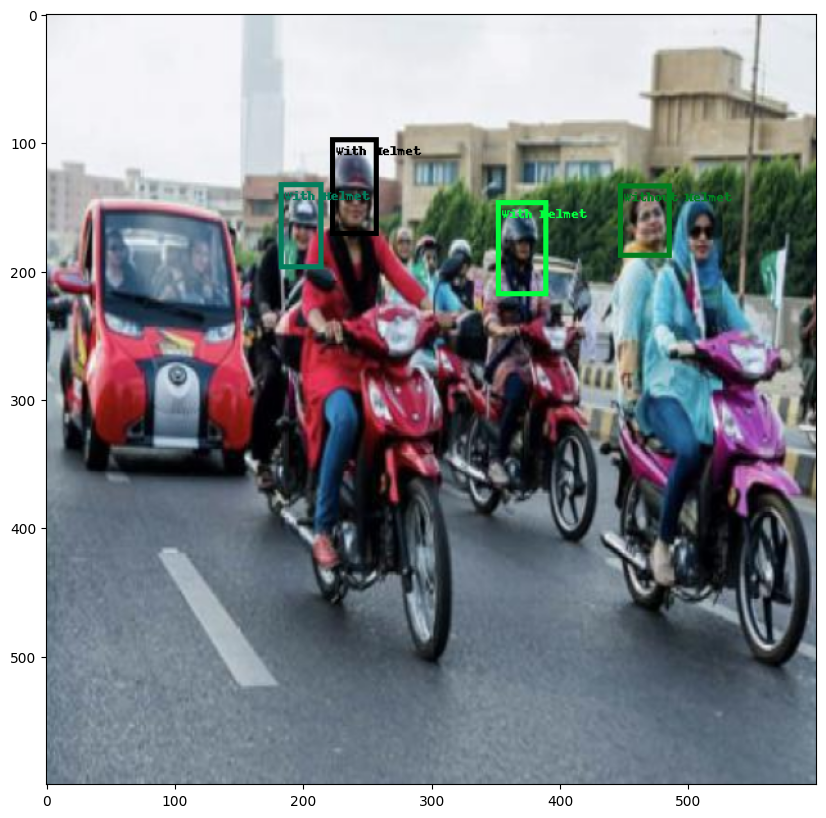

In [43]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

### Prediction

In [46]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda") # use GPU to train

classes = ['vehicles', 'Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

model = torch.load(r"/content/drive/MyDrive/best.pt")

model.eval()

img = Image.open(r"/content/drive/MyDrive/test/BikesHelmets225_png_jpg.rf.5ce1ddd4bfc514cfcc4497d40916d466.jpg")

convert_tensor = transforms.ToTensor()

img1 = convert_tensor(img)

img_int = torch.tensor(img1*255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([img1.to(device)])
    pred = prediction[0]

bbox_tensor = draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(0, 2, 1)

In [ ]:
bbox_tensor

tensor([[[182, 183, 184,  ...,   0,   0,   0],
         [177, 178, 179,  ...,   0,   0,   0],
         [180, 181, 182,  ...,   0,   0,   0],
         ...,
         [160, 159, 247,  ...,  95, 101, 104],
         [216, 201, 255,  ...,  93, 103, 108],
         [225, 202, 253,  ...,  94, 104, 109]],

        [[190, 191, 192,  ...,   0,   0,   0],
         [185, 186, 187,  ...,   0,   0,   0],
         [188, 189, 190,  ...,   0,   0,   0],
         ...,
         [135, 136, 228,  ...,  26,  20,  17],
         [193, 180, 246,  ...,  27,  20,  16],
         [204, 183, 238,  ...,  28,  20,  17]],

        [[175, 176, 177,  ...,   0,   0,   0],
         [170, 171, 172,  ...,   0,   0,   0],
         [177, 178, 179,  ...,   0,   0,   0],
         ...,
         [141, 142, 232,  ...,  29,  27,  26],
         [199, 185, 249,  ...,  31,  30,  31],
         [209, 187, 241,  ...,  32,  33,  32]]], dtype=torch.uint8)

In [47]:
transform = transforms.ToPILImage()

img = transform(bbox_tensor)

type(img)

PIL.Image.Image

In [48]:
# Converting image into base64

import base64
from io import BytesIO

buffered = BytesIO()
img.save(buffered, format="JPEG")
img_str = base64.b64encode(buffered.getvalue())

In [49]:
img_str

b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAGgAaADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDxUAd6Xanc1Bye9Lj3qLGlyUhPWm5A6UzijNAD9/oKTe3am5o3UCFye5pevemZPpS4J7UAOBAzSZ5pRG57VNFYXExARCSaLpAQZpM1v23hHU7hQwhwvqavQ+CLkn97KFrN1oLqM5PJo524Ar0zw/8AD+xvboxXcz5GOB3rd1

In [50]:
import pandas as pd

In [53]:
model = torch.load(r"/content/drive/MyDrive/best.pt")

In [54]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [55]:
model.parameters

<bound method Module.parameters of FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2):